# Intro

Примеры к книге "Глубокое обучение. Погружение в мир нейронных сетей" (Николенко, Кадурин, Архангельская).  
В книге старая версия tf 1, потому примеры переписаны на keras (tf 2).

In [ ]:
%load_ext tensorboard

In [32]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K
from keras.layers import Input, Dense, Flatten, Reshape, Dropout
from keras.models import Model 
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.regularizers import L1L2

from tqdm.keras import TqdmCallback

from visualization.plot_graph import plot_digits, plot_digits_page
from data.get_data import get_mnist

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


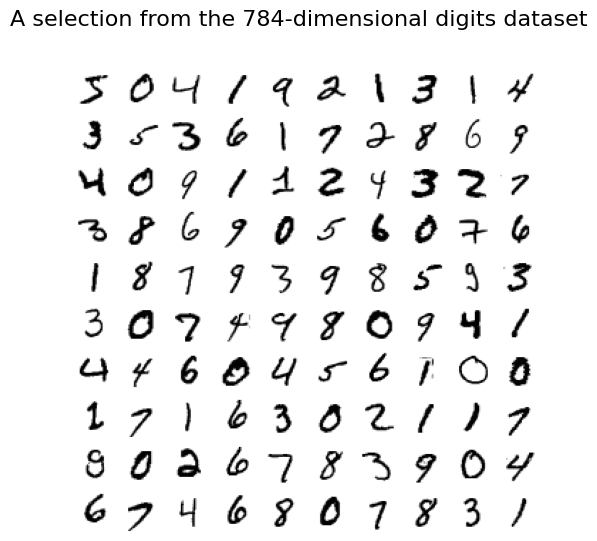

In [33]:
# Load MNIST
x_train, y_train, x_test, y_test = get_mnist()

for i in [x_train, y_train, x_test, y_test]:
    print (i.shape)

plot_digits_page(x_train)

# Простой пример (по сути логистическая регрессия)

In [34]:
# Входной плейсхолдер
# 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
input_img = Input(shape=(28, 28, 1)) 
# Решейпинг
flat_img = Flatten()(input_img)
# Выход (softmax)
output = Dense(10, activation='softmax')(flat_img)


# Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои  
# Другие модели можно так же использовать как и слои
simple_model = Model(input_img, output, name = "simple_model")

# Компилируем (построение графа вычислений)
simple_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Посмотрим на число параметров
simple_model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [35]:
# For tensorboard
log_dir = "logs/fit/00/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

simple_model_res = simple_model.fit(x_train, y_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TqdmCallback(verbose=1), tensorboard_callback],
                verbose=0,
                )

  0%|          | 0/100 [00:00<?, ?epoch/s]

100%|██████████| 100/100 [03:39<00:00,  2.20s/epoch, loss=0.281, accuracy=0.922, val_loss=0.278, val_accuracy=0.922]


<AxesSubplot:>

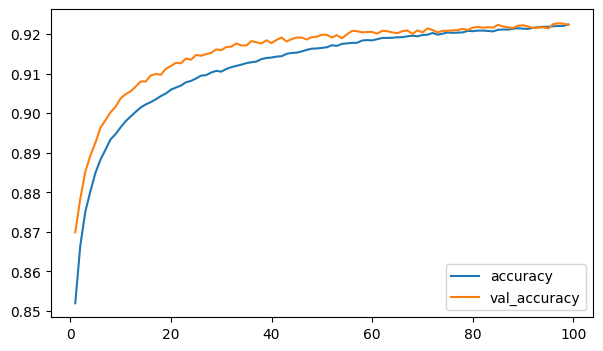

In [46]:
# Рисуем не с 1 эпохи, т.к. там совсем низкие числа
pd.DataFrame(simple_model_res.history, index = simple_model_res.epoch).loc[1:,["accuracy","val_accuracy"]].plot(figsize=(7,4))

# Простая сетка (с внутренним слоем)

С примером dropout и без такового  

In [51]:
def one_hidden_level_nn(enable_dropout: bool = True):
    # Входной плейсхолдер
    # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    input_img = Input(shape=(28, 28, 1)) 
    # Решейпинг
    flat_img = Flatten()(input_img)
    # Внутренний слой с ReLU
    hidden_layer = Dense(100, activation='relu')(flat_img)
    
    # dropout
    if enable_dropout:
        dropout_layer = Dropout(rate = 0.5)(hidden_layer)
        # Выход (softmax)
        output = Dense(10, activation='softmax')(dropout_layer)
    else:
        output = Dense(10, activation='softmax')(hidden_layer)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои  
    # Другие модели можно так же использовать как и слои
    one_hidden_level_model = Model(input_img, output, name = "simple_model")
    
    return one_hidden_level_model


one_hidden_level_model = one_hidden_level_nn(enable_dropout = False)
one_hidden_level_dropout_model = one_hidden_level_nn(enable_dropout = True)

# Компилируем (построение графа вычислений)
one_hidden_level_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
one_hidden_level_dropout_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Посмотрим на число параметров
print(one_hidden_level_model.summary())
print("-*"*40)
print(one_hidden_level_dropout_model.summary())


Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               78500     
                                                                 
 dense_15 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Model: "simple_model"
_________________________________________________________________
 Layer (

In [52]:
# w/o dropout

# For tensorboard
log_dir = "logs/fit/00_wo_dropout/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

one_hidden_level_results = one_hidden_level_model.fit(x_train, y_train,
                epochs=150,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TqdmCallback(verbose=1), tensorboard_callback],
                verbose=0,
                )

  0%|          | 0/150 [00:00<?, ?epoch/s]

100%|██████████| 150/150 [05:55<00:00,  2.37s/epoch, loss=0.0531, accuracy=0.986, val_loss=0.084, val_accuracy=0.974] 


In [53]:
# dropout enabled

# For tensorboard
log_dir = "logs/fit/00_dropout/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

one_hidden_level_dropout_results = one_hidden_level_dropout_model.fit(x_train, y_train,
                epochs=150,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TqdmCallback(verbose=1), tensorboard_callback],
                verbose=0,
                )

  0%|          | 0/150 [00:00<?, ?epoch/s]

100%|██████████| 150/150 [06:21<00:00,  2.55s/epoch, loss=0.148, accuracy=0.956, val_loss=0.0964, val_accuracy=0.971]


<AxesSubplot:>

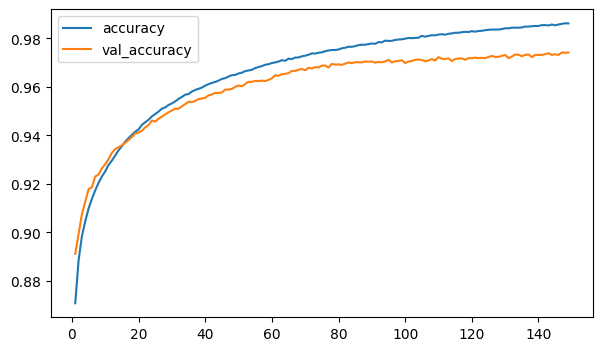

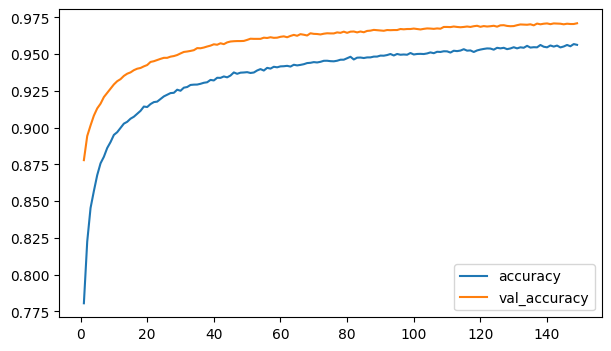

In [56]:
# Рисуем не с 1 эпохи, т.к. там совсем низкие числа

one_hidden_level_results_pdf = pd.DataFrame(one_hidden_level_results.history, index = one_hidden_level_results.epoch)
one_hidden_level_dropout_results_pdf = pd.DataFrame(one_hidden_level_dropout_results.history, index = one_hidden_level_dropout_results.epoch)

one_hidden_level_results_pdf.loc[1:,["accuracy","val_accuracy"]].plot(figsize=(7,4))
one_hidden_level_dropout_results_pdf.loc[1:,["accuracy","val_accuracy"]].plot(figsize=(7,4))

Cетку запускал и с дропаутом и без. В целом - без дропаута она стала переобучаться уже примерно после 25 эпохи (результаты на трейне стали лучше валидации, а валидация стала улучшаться медленнее).
С дропаутом такой проблемы не было - переобучения не наблюдалось, результаты на валидации увеличивались. Но сетка, судя по валидации обучилась чуть хуже, скорее всего имеет смысл использовать еще и другие способы регуляризации, или поиграть с уровнем дропаута.
